# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [5]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import chi2_contingency
%matplotlib inline

In [6]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [7]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix using Count Vectorizer
    if (not test): # fit_transform()
        cv = CountVectorizer(lowercase=True, ngram_range=(1, 3), analyzer="char_wb")
        X_cv = cv.fit_transform(movie_data.review)
        fitted_transformations.append(cv)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['repeated_word_count'] = [word for word, count in movie_data['word_count'].items() if count > 1]
    movie_data['unique_word_count'] = movie_data['review'].apply(lambda x: len(set(x.split())))
    movie_data['avg_word_length'] = movie_data['review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

    
#     # Chi-squared test to select top categorical features
#     if (not test):
#         top_features = []
#         for col in ['word_count', 'punc_count', 'repeated_words']:
#             crosstab = pd.crosstab(movie_data[col], movie_data['sentiment'])
#             chi2, p, dof, expected = chi2_contingency(crosstab)
#             if p < 0.05:
#                 top_features.append(col)
#         print("Top categorical features selected using chi-squared test: ")
#         print(top_features)
#         movie_data = movie_data[top_features]
        
        
    X_quant_features = movie_data[["word_count", "punc_count", "repeated_word_count", "unique_word_count", "avg_word_length"]]
#     X_quant_features = movie_data[top_features]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [8]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/maybaho/Documents/Parsons/Machine Learning/assignments/data/moviereviews_train.tsv', my_random_seed=13)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of CountVectorizer X:
(25000, 38406)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  repeated_word_count  unique_word_count  \
0         433          20                    0                246   
1         158        

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [9]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss", penalty="elasticnet", alpha=0.0001)
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 4614, 'TN': 5502, 'FP': 4496, 'FN': 5388, 'Accuracy': 0.5058, 'Precision': 0.506476399560922, 'Recall': 0.46130773845230955, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [10]:
from sklearn import linear_model

#regularization alpha=300 obtained from canvas assignment 3
svm = linear_model.SGDClassifier(alpha=250)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 8959, 'TN': 7548, 'FP': 2450, 'FN': 1043, 'Accuracy': 0.82535, 'Precision': 0.785257253045841, 'Recall': 0.8957208558288342, 'desc': 'svm_train'}


### MODEL: logistic regression

In [11]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB

#add regularization to reduce overfitting
nbs = MultinomialNB(fit_prior=True, alpha=0.001)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9003, 'TN': 9130, 'FP': 868, 'FN': 999, 'Accuracy': 0.90665, 'Precision': 0.9120656468442914, 'Recall': 0.9001199760047991, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [13]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [14]:
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X_train, y_train)

# rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
# rdg_performance_train.compute_measures()
# print(rdg_performance_train.performance_measures)

### MODEL: Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 7769, 'TN': 7637, 'FP': 2361, 'FN': 2233, 'Accuracy': 0.7703, 'Precision': 0.7669299111549852, 'Recall': 0.7767446510697861, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

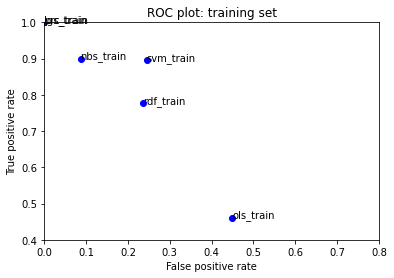

In [16]:
fits = [nbs_performance_train, svm_performance_train, ols_performance_train, lgs_performance_train, prc_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.8, 0.4, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [17]:
nbs_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [18]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
549
A craven, cowardly film. Director Boorman shows Cahill burglarizing rich houses, but the male occupant is shown being unfaithful with the nanny, thats all right then. The forensic scientist investigating Cahill is blown up in his car, but he is rat faced sourpuss, and doesn't look like a nice man, so thats all right too. The Beits, owner of Russborrough House, made their money by exploiting 'darkies' digging up diamonds, so it's okay to rob priceless art from them and hide it in a bunker in the Wicklow mountains. The Garda kill his ferrets and are implicated in his murder. The moral equivalencing is sickening, Boorman looks for a hit film, but doesn't have the guts to stand against the criminality of the generals gang, who terrorized the neighbourhood, and unleashed another wave of scumbags upon Dublin. He even liaised with the Generals son while making it. Disgusting. Shame on him for his cowardice.
* * * * * * * * * 
731
It's kind of fascinating to me

3742
I just finished watching \El Otro\". I have always taken my hat off to Julio Chavez's performances, as he is a great actor, but this movie is really depressing and slow. I guess that it would have been even worse if it wasn't for Julio. Anyways, this is definitely a film that you will never understand if you are not from Argentina, and even if you are, I would advise you not to rent this movie in order to have a nice time with your girlfriend, boyfriend, family or friends... it is really depressing and incredibly slow, and the plot does not make a lot of sense neither. Probably the director wanted to show the fragility of the human life, but what he does is bore and impress the audience with scenes that shock you a little bit. It gives you something to think about, but not in a good way. Overall, I definitely didn't like this movie."
* * * * * * * * * 
3744
This is said to be a personal film for Peter Bogdonavitch. He based it on his life but changed things around to fit the chara

6966
Germans think smirking is funny (just like Americans think mumbling is sexy and that women with English accents are acting). I had to cross my eyes whenever the screen was filled yet again with a giant close-up of a smirking face. One of those 'housewife hacks corporate mainframe' tales where she defrauds a bank by tapping a few random keys on her home PC which is connected only to a power socket. The director obviously loves the rather large leading lady. Can't say I share his feelings. There's quite a funny bit when the entire family sit in front of the television chanting tonelessly along with the adverts. Apparently this review needs to be one line longer so here it is.
* * * * * * * * * 
7493
It's frequently said that movies can never equal the original book. Well, in this case, not only the movie is not \as good\" as the book, but is an insult to the book. I'd rather see Milan Kundera's novel turned on fire than into this \"something,\" which the director probably calls \"ad

10268
Not even Bob Hope, escorted by a raft of fine character actors, can save this poorly written attempt at wartime comedy, as his patented timing has little which which to work. The plot involves a Hollywood film star named Don Bolton (Hope), and his attempt to evade military service at the beginning of World War II, followed by his enlistment by mistake in a confused attempt to court a colonel's daughter (Dorothy Lamour). Bolton's agent, played by Lynne Overman, and his assistant, portrayed by Eddie Bracken, enlist with him and the three are involved in various escapades regarding training exercises, filmed in the Malibu, California, hills. Paramount budgeted handsomely for this effort, employing some of its top specialists, but direction by the usually reliable David Butler was flaccid, and this must be attributed to a missing comedic element in the scenario. A shift toward the end of the film to create an opportunity for heroism by Bolton is still-born with poor stunt work and ca

13655
One of the requirements of science fiction, at least before it starts to become satire, is that it be somewhat plausible. I would think that an anti-matter bomb would do considerably more damage than for what it was intended. But I'll leave that to the physicists who might have seen Solar Crisis.<br /><br />It is a crisis the earth is facing because solar flares are getting totally out of hand. They're getting close to Earth, so much so that it's become unseasonably hot, as if the entire Earth were Death Valley. The answer is an anti-matter bomb which a space ship will have to take to the sun and explode it there. That will divert the flares off in say the direction of say Mercury providing it's not in direct alignment with the Earth. <br /><br />Who to deliver it, but captain Tim Matheson and his crew. That is if he can keep his mind on the business at hand and not on runaway son, Corin Nemec. Taking care of the personal side of the family problems is admiral Charlton Heston, Ma

17694
I found this film to be quite an oddity. From the very get go I found it extremely hard to like this movie, and now after a little thinking about it I can pretty much pinpoint the reason why. Jean-Marc Barr, although I love him to bits (I think Zentropa is one of the best movies ever made) is quite miscast here, and although I can't figure for the life of me who would be better, I am sure someone could have taken his place quite easily and make this film work. Everything else is fine, except for the stabs at weak comedy (A Meet The Parents Joke is not really needed, filmmakers!) and I really like Richard E. Grant as the British Major. It just suffers from one thing.. Jean-Marc.
* * * * * * * * * 
18480
This Kiyoshi Kurosawa ghost movie is pretty wild, and it did have at least one jump scare that caught me off guard. But all in all, the movie is incredibly stupid, with a detective trying to track down a suspected serial killer, only to find out he may have committed one of the cri

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [19]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [20]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2156, 'TN': 1757, 'FP': 745, 'FN': 342, 'Accuracy': 0.7826, 'Precision': 0.7431920027576697, 'Recall': 0.8630904723779024, 'desc': 'svm_test'}


### MODEL: logistic regression

In [21]:
# lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
# lgs_performance_test.compute_measures()
# print(lgs_performance_test.performance_measures)

### MODEL: Naive Bayes

In [22]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 1725, 'TN': 1762, 'FP': 740, 'FN': 773, 'Accuracy': 0.6974, 'Precision': 0.6997971602434077, 'Recall': 0.6905524419535628, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [23]:
# prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
# prc_performance_test.compute_measures()
# print(prc_performance_test.performance_measures)

### MODEL: Ridge Regression Classifier

In [24]:
# rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
# rdg_performance_test.compute_measures()
# print(rdg_performance_test.performance_measures)

### MODEL: Random Forest Classifier

In [25]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

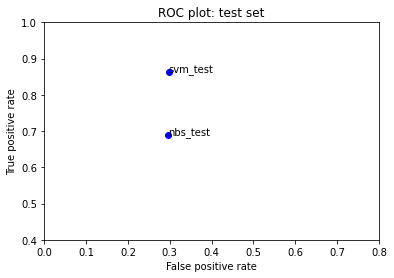

In [26]:
fits = [nbs_performance_test, svm_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.8, 0.4, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [68]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/maybaho/Documents/Parsons/Machine Learning/assignments/data/moviereviews_test.tsv', my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of CountVectorizer X:
(25000, 38406)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  repeated_word_count  unique_word_count  \
0         131           5                    0                 92   
1         169          15                    1                117   
2         176          18                    2                129   
3         112    

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [72]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.60232


In [73]:
raw_data.head()

,id,review,word_count,punc_count,repeated_word_count,unique_word_count,avg_word_length
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,92,4.877863
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1,117,4.307692
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,2,129,4.619318
3,7186_2,Afraid of the Dark left me with the impression...,112,5,3,87,4.875000
4,12128_7,A very accurate depiction of small time mob li...,133,8,4,111,4.736842


In [74]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1


In [75]:
my_submission.shape

(25000, 2)

In [76]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/maybaho/Documents/Parsons/Machine Learning/assignments/final_assignment_1/iterations/iteration 1/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation